In [3]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
import random
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [31]:
list_of_action = {
    0: (0,0),
    1: (0,1),
    2: (0,2),
    3: (1,0),
    4: (1,1),
    5: (1,2),
    6: (2,0),
    7: (2,1),
    8: (2,2)
}

rev_action = {
    (0,0) :0,
    (0,1) :1,
    (0,2) :2,
    (1,0) :3,
    (1,1) :4,
    (1,2) :5,
    (2,0) :6,
    (2,1) :7,
    (2,2) :8
}

In [43]:
### function to change the state from (3,3) to (3,3,2) as asked in the question
def make_state_for_input(obs_env):
    output = np.zeros((3,3,2))
    for i in range(3):
        for j in range(3):
            if obs_env[i,j] == 1:
                output[i,j,0] = 1
            elif obs_env[i,j] == -1:
                output[i,j,1] = 1
    return output


check_state = np.array([[1,0,-1],[0,0,1],[0,-1,0]])
make_state_for_input(check_state).shape, make_state_for_input(check_state)[:,:,0], make_state_for_input(check_state)[:,:,1]

((3, 3, 2),
 array([[1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 0.]]),
 array([[0., 0., 1.],
        [0., 0., 0.],
        [0., 1., 0.]]))

In [193]:
BATCH_SIZE = 64
GAMMA = 0.99
BUFFER_SIZE = 10000
MIN_REPLAY_SIZE = 40
TARGET_UPDATE_FREQ = 500


## Defining the network
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        in_features = int(3*3*2)
        
        self.net = nn.Sequential(
            nn.Linear(in_features,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,9)
        )

    def forward(self,x):
        return self.net((x.view(x.size(0), -1)))

    def act(self,obs):
        obs_t = torch.as_tensor(obs, dtype=torch.float32)
        q_values = self(obs_t.unsqueeze(0))

        max_q_index = torch.argmax(q_values,dim=1)[0]
        action = max_q_index.detach().item()
        return action


env = TictactoeEnv()


#replay buffer for storing the transitions
replay_buffer = deque(maxlen=BUFFER_SIZE)
rew_buffer = deque([0.], maxlen=100) 

episode_reward = 0.


policy_net = Network() 
target_net = Network() 
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.Adam(policy_net.parameters(), lr=5e-4)

In [133]:
target_net.parameters

<bound method Module.parameters of Network(
  (net): Sequential(
    (0): Linear(in_features=18, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=9, bias=True)
  )
)>

In [230]:
##Function to find M_opt and M_rand
## eps: the argument is the argument eps_opt for the env 
## and then the function runs 500 games and find wins by computer and wins by our agent
def number_wins(eps):    
      N_win = 0
      N_wino = 0
      draw = 0
      for games in range(500):

            env.reset()
            if games%2 == 0:
                  opt_player = OptimalPlayer(epsilon = eps, player = 'O')

            if games%2 == 1:
                  opt_player = OptimalPlayer(epsilon = eps, player = 'X')
                  grid, _, __ = env.observe()
                  comp_move = opt_player.act(grid)
                  env.step(comp_move)
      
            for rounds in range(5):
                  state_now = env.observe()[0]
                  best_action1 = policy_net.act(make_state_for_input(state_now))

                  if state_now[list_of_action[best_action1]] != 0:
                        N_wino = N_wino+1
                        break
        
                  #make the move with that best action
                  env.step(best_action1)
                  
                  grid, _, __ = env.observe()
        
                  if env.observe()[1] == True:
                        if str(env.winner) == 'X' and games%2 == 0:
                              N_win = N_win+1
                        elif str(env.winner) == 'O' and games%2 == 0:
                              N_wino = N_wino+1
                        elif str(env.winner) == 'O' and games%2 == 1:
                              N_win = N_win+1
                        elif str(env.winner) == 'X' and games%2 == 1:
                              N_wino = N_wino+1
                        else:
                              draw = draw+1
                        break
                  
                  #Now the computer plays (for a fair game ahaha)
                  comp_move = opt_player.act(grid)
                  env.step(comp_move)

                  if env.observe()[1] == True:
                        if str(env.winner) == 'X' and games%2 == 0:
                              N_win = N_win+1
                        elif str(env.winner) == 'O' and games%2 == 0:
                              N_wino = N_wino+1
                        elif str(env.winner) == 'O' and games%2 == 1:
                              N_win = N_win+1
                        elif str(env.winner) == 'X' and games%2 == 1:
                              N_wino = N_wino+1
                        else:
                              draw = draw+1
                        break

      return N_win, N_wino


In [195]:
env.reset()

state_zero = env.observe()[0]
##Intialising a buffer with random moves
for games in range(300):
    env.reset()

    if games%2 == 0:
        player1 = "X"
        player2 = "O"
        opt_player = OptimalPlayer(epsilon = 0.5, player = player2)
    if games%2 == 1:
        player1 = "O"
        player2 = "X"
        opt_player = OptimalPlayer(epsilon = 0.5, player = player2)
        grid, _, __ = env.observe()
        comp_move = opt_player.act(grid)
        env.step(comp_move)


    for rounds in range(5):

        #I play
        state_now = env.observe()[0]
        best_action1 = np.random.randint(0,9)
        
        ###For the case if you can not take the action
        if state_now[list_of_action[best_action1]] != 0:
            end = True
            rew = -1
            transition = (state_now, best_action1, rew, end, state_zero)
            replay_buffer.append(transition)
            episode_reward += rew
            rew_buffer.append(episode_reward)
            episode_reward = 0.
            break

        #make the move with that best action (here random action cause we are just initialising the buffer randomly)
        env.step(best_action1)

        grid, _, __ = env.observe()
        if env.observe()[1] == True:
            rew = env.reward(player=player1)
            transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
            replay_buffer.append(transition)
            episode_reward += rew
            rew_buffer.append(episode_reward)
            episode_reward = 0.
            break
        
        #Now the computer plays (for a fair game ahaha)
        comp_now = env.observe()[0]
        comp_move = opt_player.act(grid)
        env.step(comp_move)

        if env.observe()[1] == True:
            rew = env.reward(player=player1)
            transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
            replay_buffer.append(transition)
            episode_reward += rew
            rew_buffer.append(episode_reward)
            episode_reward = 0.
            break

        #Gather information about the state the game is in after the computer played
        future_state = env.observe()[0]
        
        _, end, winner = env.observe()
        rew = env.reward(player=player1)                    
        transition = (state_now, best_action1, rew, end, future_state)
        replay_buffer.append(transition)
        episode_reward += rew
        


In [196]:
##############MAIN TRAINING LOOP

##List to store variables we would like to see how they vary with the training
M_opt = []
M_rand = []
average_reward = []
average_loss = []


current_average_reward = 0
current_training_loss = 0
env.reset()
obs = env.observe()[0]
zero_state = env.observe()[0]
epsilon = 0.


for games in range(20000):
    env.reset()
    epsilon = 0.
    obs = env.observe()[0]

    ####To keep the number of times we played first and the times computer played first equal
    if games%2 == 0:
        player1 = "X"
        player2 = "O"
        opt_player = OptimalPlayer(epsilon = 0.5, player = player2)
    if games%2 == 1:
        player1 = "O"
        player2 = "X"
        opt_player = OptimalPlayer(epsilon = 0.5, player = player2)
        grid, _, __ = env.observe()
        comp_move = opt_player.act(grid)
        env.step(comp_move)


    #updating the required lists after each 250 games are played
    if games%250 == 0:
        average_reward.append(current_average_reward/250)
        current_average_reward = 0
        print()
        print(current_training_loss/250)
        average_loss.append(current_training_loss/250)
        current_training_loss = 0


    #playing a game
    for rounds in range(5):

        #I play
        state_now = env.observe()[0]

        #selecting the best action considering the present state based on epsilon greedy policy
        if epsilon == 0.:
            best_action1 = policy_net.act(make_state_for_input(state_now))
        else:
            random_number = np.random.randint(0,10)
            if random_number >= epsilon*10:
                best_action1 = policy_net.act(make_state_for_input(state_now))
            else:
                best_action1 = random_number
        
        
        ###For the case when we take an unavailable action 
        if state_now[list_of_action[best_action1]] != 0:
            end = True
            rew = -1
            current_average_reward += -1
            transition = (state_now, best_action1, rew, end, zero_state)
            replay_buffer.append(transition)
            episode_reward += rew
            rew_buffer.append(episode_reward)
            episode_reward = 0.
            break

        #make the move with that best action
        env.step(best_action1)

        
        grid, _, __ = env.observe()
        
        if env.observe()[1] == True:
            rew = env.reward(player=player1)
            current_average_reward += rew
            transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
            replay_buffer.append(transition)
            episode_reward += rew
            rew_buffer.append(episode_reward)
            episode_reward = 0.
            break
        
        #Now the computer plays (for a fair game ahaha)
        comp_now = env.observe()[0]
        comp_move = opt_player.act(grid)
        env.step(comp_move)

        if env.observe()[1] == True:
            rew = env.reward(player=player1)
            current_average_reward += rew
            transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
            replay_buffer.append(transition)
            episode_reward += rew
            rew_buffer.append(episode_reward)
            episode_reward = 0.
            break

        #Gather information about the state the game is in after the computer played
        future_state = env.observe()[0]
        
        _, end, winner = env.observe()
        rew = env.reward(player=player1)                    
        transition = (state_now, best_action1, rew, end, future_state)
        replay_buffer.append(transition)
        episode_reward += rew
        




    ##START GRADIENT STEP
    transitions = random.sample(replay_buffer, BATCH_SIZE)

    obses = np.asarray([make_state_for_input(t[0]) for t in transitions])
    actions = np.asarray([t[1] for t in transitions])
    rew = np.asarray([t[2] for t in transitions])
    dones = np.asarray([t[3] for t in transitions])
    new_obses = np.asarray([make_state_for_input(t[4]) for t in transitions])

    obses_t = torch.as_tensor(obses, dtype=torch.float32)
    actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
    rews_t = torch.as_tensor(rew, dtype=torch.float32).unsqueeze(-1)
    dones_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
    new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32)

    target_q_values = target_net(new_obses_t)
    
    max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
    
    targets = rews_t + GAMMA * (1 - dones_t) * max_target_q_values


    ###COMPUTE LOSS
    q_values = policy_net(obses_t)
    action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)

    loss = nn.functional.smooth_l1_loss(action_q_values, targets)
    current_training_loss += loss.item()

    ####GRADIENT STEP
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ####UPDATE TARGET NETWORK
    if games % TARGET_UPDATE_FREQ == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if games % 500 == 0:
        print()
        print("game",games)
        print("Avg_rew", np.mean(rew_buffer))
        print("Loss", loss)
        N_me, N_comp = number_wins(0.)
        print("M_opt",N_me,N_comp)
        M_opt.append((N_me-N_comp)/500)
        N_me, N_comp = number_wins(1.)
        print("M_rand",N_me,N_comp)
        M_rand.append((N_me-N_comp)/500)
        



0.0

game 0
Avg_rew -0.94
Loss tensor(0.1857, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 500
M_rand 0 500

0.08401154626905918

0.05592607942968607

game 500
Avg_rew -0.43
Loss tensor(0.0499, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 500
M_rand 282 166

0.054647793389856814

0.051214788176119325

game 1000
Avg_rew -0.16
Loss tensor(0.0526, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 369
M_rand 310 108

0.05906493644416332

0.053771414004266264

game 1500
Avg_rew 0.01
Loss tensor(0.0589, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 92
M_rand 314 62

0.06385180258750915

0.06282927667349578

game 2000
Avg_rew 0.09
Loss tensor(0.0628, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 250
M_rand 372 70

0.06451925633847713

0.06173103923350572

game 2500
Avg_rew 0.23
Loss tensor(0.0825, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 203
M_rand 398 43

0.06397559176385402

0.0606743690147996

game 3000
Avg_rew 0.49
Loss tensor(0.0700, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 166
M_rand 426 29

0.06195304243266583


# Question 11

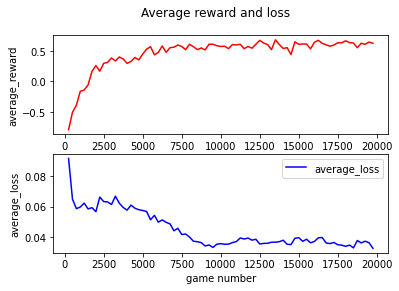

In [145]:
game_number = []
for i in range(80):
    game_number.append(250*i)
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Average reward and loss')
ax1.plot(game_number[1:],average_reward[1:],color='r',label='average_reward')
ax2.plot(game_number[1:],average_loss[1:], color="b",label="average_loss")

ax1.set(xlabel='game_number', ylabel='average_reward')
ax2.set(xlabel='game_number', ylabel='average_loss')

plt.xlabel("game number")
plt.legend()
plt.savefig('Ques11.png')
plt.savefig('Ques11.pdf')
plt.show()

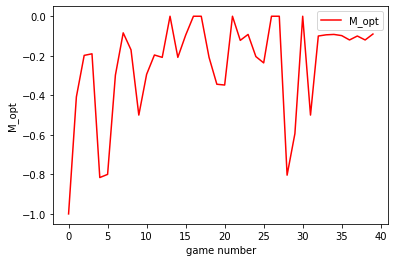

In [146]:

plt.plot(M_opt,color='r',label='M_opt')
plt.ylabel("M_opt")
plt.xlabel("game number")
plt.legend()
plt.show()

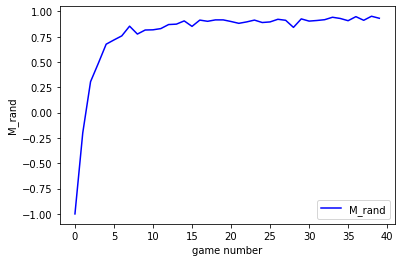

In [147]:
plt.plot(M_rand,color='b',label='M_rand')
plt.ylabel("M_rand")
plt.xlabel("game number")
plt.legend()
plt.show()

In [148]:
number_wins(0.)

(0, 59)

In [149]:
number_wins(1.)

(474, 5)

# Question 12

In [178]:
BATCH_SIZE = 1
GAMMA = 0.99
BUFFER_SIZE = 10000
MIN_REPLAY_SIZE = 40
TARGET_UPDATE_FREQ = 500


###Defining the network
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        in_features = int(3*3*2)
        
        self.net = nn.Sequential(
            nn.Linear(in_features,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,9)
        )

    def forward(self,x):
        return self.net((x.view(x.size(0), -1)))

    def act(self,obs):
        obs_t = torch.as_tensor(obs, dtype=torch.float32)
        q_values = self(obs_t.unsqueeze(0))

        max_q_index = torch.argmax(q_values,dim=1)[0]
        action = max_q_index.detach().item()
        return action


env = TictactoeEnv()

replay_buffer = deque(maxlen=BUFFER_SIZE)
rew_buffer = deque([0.], maxlen=100) #MAYBE 10 is better

episode_reward = 0.


policy_net = Network() #.to("cpu")
target_net = Network() #.to("cpu")
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.Adam(policy_net.parameters(), lr=5e-4)

In [179]:
##############MAIN TRAINING LOOP#########HERE BATCH SIZE IS KEPT AS 1 and without any replay buffer

##Lists to store M_opt, average_reward and other variables of interest
M_opt = []
M_rand = []
average_reward = []
average_loss = []


current_average_reward = 0
current_training_loss = 0
env.reset()
obs = env.observe()[0]
zero_state = env.observe()[0]

epsilon = 0.
for games in range(20000):
    
    env.reset()
    epsilon = 0.
    obs = env.observe()[0]
    action = policy_net.act(make_state_for_input(obs))

    ####To keep the number of times we played first and the times computer played first equal
    if games%2 == 0:
        player1 = "X"
        player2 = "O"
        opt_player = OptimalPlayer(epsilon = 0.5, player = player2)
    if games%2 == 1:
        player1 = "O"
        player2 = "X"
        opt_player = OptimalPlayer(epsilon = 0.5, player = player2)
        grid, _, __ = env.observe()
        comp_move = opt_player.act(grid)
        env.step(comp_move)

    #updating the required lists after each 250 games are played
    if games%250 == 0:
        average_reward.append(current_average_reward/250)
        current_average_reward = 0
        print()
        print(current_training_loss/250)
        average_loss.append(current_training_loss/250)
        current_training_loss = 0


    ##Playing the game
    for rounds in range(5):
        
        #I play
        state_now = env.observe()[0]
        #selecting the best action considering the present state
        if epsilon == 0.:
            best_action1 = policy_net.act(make_state_for_input(state_now))
        else:
            random_number = np.random.randint(0,10)
            if random_number >= epsilon*10:
                best_action1 = policy_net.act(make_state_for_input(state_now))
            else:
                best_action1 = random_number
        
        ###For the case when you take an unavilable action
        if state_now[list_of_action[best_action1]] != 0:
            end = True
            rew = -1
            current_average_reward += -1
            transition = (state_now, best_action1, rew, end, zero_state)
            episode_reward += rew
            rew_buffer.append(episode_reward)
            episode_reward = 0.
            

            ###Preparing for a stochastic update (Where we update just based after every transition)
            obses = np.asarray(make_state_for_input(transition[0]))
            actions = np.asarray(transition[1])
            rew = np.asarray(transition[2])
            dones = np.asarray(transition[3])
            new_obses = np.asarray(make_state_for_input(transition[4]))

            obses_t = torch.as_tensor(obses, dtype=torch.float32)
            actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
            rews_t = torch.as_tensor(rew, dtype=torch.float32).unsqueeze(-1)
            dones_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
            new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32)
            
            target_q_values = target_net(new_obses_t[None,:,:,:])
            max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
            targets = rews_t + GAMMA * (1 - dones_t) * max_target_q_values

            ###COMPUTE LOSS
            q_values = policy_net(obses_t[None,:,:,:])
            action_q_values =  q_values[:,actions_t]

            loss = nn.functional.smooth_l1_loss(action_q_values, targets)
            current_training_loss += loss.item()

            ####GRADIENT STEP
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            break

        #make the move with that best action
        env.step(best_action1)

        #Now the computer plays (for a fair game ahaha)
        grid, _, __ = env.observe()
        
        if env.observe()[1] == True:
            rew = env.reward(player=player1)
            current_average_reward += rew
            transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
            episode_reward += rew
            rew_buffer.append(episode_reward)
            episode_reward = 0.


            ###Preparing for a stochastic update (Where we update just based after every transition)
            obses = np.asarray(make_state_for_input(transition[0]))
            actions = np.asarray(transition[1])
            rew = np.asarray(transition[2])
            dones = np.asarray(transition[3])
            new_obses = np.asarray(make_state_for_input(transition[4]))

            obses_t = torch.as_tensor(obses, dtype=torch.float32)
            actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
            rews_t = torch.as_tensor(rew, dtype=torch.float32).unsqueeze(-1)
            dones_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
            new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32)
            
            target_q_values = target_net(new_obses_t[None,:,:,:])
            max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
            targets = rews_t + GAMMA * (1 - dones_t) * max_target_q_values
            ###COMPUTE LOSS
            q_values = policy_net(obses_t[None,:,:,:])
            action_q_values =  q_values[:,actions_t]       

            loss = nn.functional.smooth_l1_loss(action_q_values, targets)
            current_training_loss += loss.item()

            ####GRADIENT STEP
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            break
        
        comp_now = env.observe()[0]
        comp_move = opt_player.act(grid)
        env.step(comp_move)

        if env.observe()[1] == True:
            rew = env.reward(player=player1)
            current_average_reward += rew
            transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
            episode_reward += rew
            rew_buffer.append(episode_reward)
            episode_reward = 0.

            ###Preparing for a stochastic update (Where we update just based after every transition)
            obses = np.asarray(make_state_for_input(transition[0]))
            actions = np.asarray(transition[1])
            rew = np.asarray(transition[2])
            dones = np.asarray(transition[3])
            new_obses = np.asarray(make_state_for_input(transition[4]))

            obses_t = torch.as_tensor(obses, dtype=torch.float32)
            actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
            rews_t = torch.as_tensor(rew, dtype=torch.float32).unsqueeze(-1)
            dones_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
            new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32)
            
            target_q_values = target_net(new_obses_t[None,:,:,:])
            max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
            targets = rews_t + GAMMA * (1 - dones_t) * max_target_q_values
            ###COMPUTE LOSS
            q_values = policy_net(obses_t[None,:,:,:])
            action_q_values =  q_values[:,actions_t]       

            loss = nn.functional.smooth_l1_loss(action_q_values, targets)
            current_training_loss += loss.item()

            ####GRADIENT STEP
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            break

        #Gather information about the state the game is in after the computer played
        future_state = env.observe()[0]
        
        _, end, winner = env.observe()
        rew = env.reward(player=player1)                    
        transition = (state_now, best_action1, rew, end, future_state)
        episode_reward += rew


        obses = np.asarray(make_state_for_input(transition[0]))
        actions = np.asarray(transition[1])
        rew = np.asarray(transition[2])
        dones = np.asarray(transition[3])
        new_obses = np.asarray(make_state_for_input(transition[4]))

        obses_t = torch.as_tensor(obses, dtype=torch.float32)
        actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
        rews_t = torch.as_tensor(rew, dtype=torch.float32).unsqueeze(-1)
        dones_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
        new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32)
            
        target_q_values = target_net(new_obses_t[None,:,:,:])
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = rews_t + GAMMA * (1 - dones_t) * max_target_q_values
            ###COMPUTE LOSS
        q_values = policy_net(obses_t[None,:,:,:])
        action_q_values =  q_values[:,actions_t]       

        loss = nn.functional.smooth_l1_loss(action_q_values, targets)
        current_training_loss += loss.item()

            ####GRADIENT STEP
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

    ####UPDATE TARGET NETWORK
    if games % TARGET_UPDATE_FREQ == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if games % 500 == 0:
        print()
        print("game",games)
        print("Avg_rew", np.mean(rew_buffer))
        print("Loss", loss)
        N_me, N_comp = number_wins(0.)
        print("M_opt",N_me,N_comp)
        M_opt.append((N_me-N_comp)/500)
        N_me, N_comp = number_wins(1.)
        print("M_rand",N_me,N_comp)
        M_rand.append((N_me-N_comp)/500)
        



0.0

game 0
Avg_rew -0.5
Loss tensor(0.5840, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 500
M_rand 0 500

0.5240505524817854

0.33637722590297925

game 500
Avg_rew -0.24
Loss tensor(1.2310, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 500
M_rand 337 137

0.348374530255438

0.23121803837042512

game 1000
Avg_rew 0.1
Loss tensor(0.0029, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 250
M_rand 376 111

0.17987131008396734

0.15871027796545545

game 1500
Avg_rew 0.18
Loss tensor(0.0040, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 250
M_rand 377 85

0.1472910852869819

0.13654079243287823

game 2000
Avg_rew -0.08
Loss tensor(0.0048, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 500
M_rand 357 135

0.1914707677609429

0.15860485076951228

game 2500
Avg_rew 0.22
Loss tensor(0.0617, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 192
M_rand 379 101

0.15955900622506805

0.12162323661230676

game 3000
Avg_rew 0.19
Loss tensor(0.0002, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 411
M_rand 397 68

0.09228642096115737

0.116

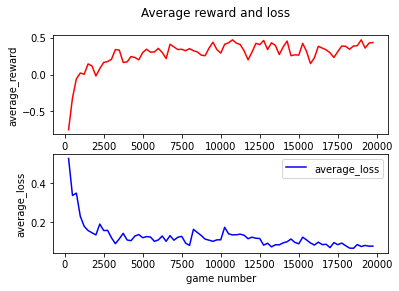

In [181]:
game_number = []
for i in range(80):
    game_number.append(250*i)
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Average reward and loss')
ax1.plot(game_number[1:],average_reward[1:],color='r',label='average_reward')
ax2.plot(game_number[1:],average_loss[1:], color="b",label="average_loss")

ax1.set(xlabel='game_number', ylabel='average_reward')
ax2.set(xlabel='game_number', ylabel='average_loss')

plt.xlabel("game number")
plt.legend()
plt.savefig('Ques12.png')
plt.savefig('Ques12.pdf')
plt.show()

# Question 13

In [197]:
### SAME STUFF ALL OVER AGAIN

BATCH_SIZE = 64
GAMMA = 0.99
BUFFER_SIZE = 10000
MIN_REPLAY_SIZE = 40
TARGET_UPDATE_FREQ = 500

def epsilon_fxn(n,n_star):
    return np.maximum(0.1,0.8*(1-(n/n_star)))

class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        in_features = int(3*3*2)
        
        self.net = nn.Sequential(
            nn.Linear(in_features,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,9)
        )

    def forward(self,x):
        return self.net((x.view(x.size(0), -1)))

    def act(self,obs):
        obs_t = torch.as_tensor(obs, dtype=torch.float32)
        q_values = self(obs_t.unsqueeze(0))

        max_q_index = torch.argmax(q_values,dim=1)[0]
        action = max_q_index.detach().item()
        return action


env = TictactoeEnv()

replay_buffer = deque(maxlen=BUFFER_SIZE)
rew_buffer = deque([0.], maxlen=100) 

episode_reward = 0.


policy_net = Network() 
target_net = Network() 
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.Adam(policy_net.parameters(), lr=5e-4)

In [199]:

##Function to intialise replay buffer with random transitons tuple
def initialise_replay_buffer():
    episode_reward = 0.
    replay_buffer = deque(maxlen=BUFFER_SIZE)
    env.reset()

    state_zero = env.observe()[0]

    for games in range(300):
        env.reset()

        if games%2 == 0:
            player1 = "X"
            player2 = "O"
            opt_player = OptimalPlayer(epsilon = 0.5, player = player2)
        if games%2 == 1:
            player1 = "O"
            player2 = "X"
            #change the state by *-1 when best player is X
            opt_player = OptimalPlayer(epsilon = 0.5, player = player2)
            grid, _, __ = env.observe()
            comp_move = opt_player.act(grid)
            env.step(comp_move)


        for rounds in range(5):

            #I play
            state_now = env.observe()[0]
            #selecting the best action considering the present state
            best_action1 = np.random.randint(0,9)
            
            ###If you can not take the action??
            if state_now[list_of_action[best_action1]] != 0:
                end = True
                rew = -1
                transition = (state_now, best_action1, rew, end, state_zero)
                replay_buffer.append(transition)
                episode_reward += rew
                rew_buffer.append(episode_reward)
                episode_reward = 0.
                break

            #make the move with that best action
            env.step(best_action1)

            #Now the computer plays (for a fair game ahaha)
            grid, _, __ = env.observe()
            
            if env.observe()[1] == True:
                rew = env.reward(player=player1)
                transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
                replay_buffer.append(transition)
                episode_reward += rew
                rew_buffer.append(episode_reward)
                episode_reward = 0.
                break
            
            
            comp_now = env.observe()[0]
            comp_move = opt_player.act(grid)
            env.step(comp_move)

            if env.observe()[1] == True:
                rew = env.reward(player=player1)
                transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
                replay_buffer.append(transition)
                episode_reward += rew
                rew_buffer.append(episode_reward)
                episode_reward = 0.
                break

            #Gather information about the state the game is in after the computer played
            future_state = env.observe()[0]
            
            _, end, winner = env.observe()
            rew = env.reward(player=player1)                    ##HAVE TO CHANGE ACCORDING TO THE PLAYER
            transition = (state_now, best_action1, rew, end, future_state)
            replay_buffer.append(transition)
            episode_reward += rew
            
    return replay_buffer
replay_buffer = initialise_replay_buffer()

In [200]:
##############MAIN TRAINING LOOP

M_opt = [[],[],[],[],[],[]]
M_rand = [[],[],[],[],[],[]]

## Training for different n* to see the effect of the epsilon decay
n_star_list = [1, 1000, 5000, 10000, 20000, 40000]


env.reset()
obs = env.observe()[0]
zero_state = env.observe()[0]


for z in range(6):

    policy_net = Network() 
    target_net = Network() 
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = torch.optim.Adam(policy_net.parameters(), lr=5e-4)
    repplay_buffer = initialise_replay_buffer()

    for games in range(20000):
        
        env.reset()
        epsilon_moving = epsilon_fxn(games,n_star_list[z])
        obs = env.observe()[0]
        
        if games%2 == 0:
            player1 = "X"
            player2 = "O"
            opt_player = OptimalPlayer(epsilon = 0.5, player = player2)
        if games%2 == 1:
            player1 = "O"
            player2 = "X"
            #change the state by *-1 when best player is X
            opt_player = OptimalPlayer(epsilon = 0.5, player = player2)
            grid, _, __ = env.observe()
            comp_move = opt_player.act(grid)
            env.step(comp_move)

        for rounds in range(5):
            
            #I play
            state_now = env.observe()[0]
            #selecting the best action considering the present state
            if epsilon_moving == 0.:
                best_action1 = policy_net.act(make_state_for_input(state_now))
            else:
                random_number = np.random.randint(0,9)
                if random_number >= epsilon_moving*10:
                    best_action1 = policy_net.act(make_state_for_input(state_now))
                else:
                    best_action1 = random_number
            
            ###For the case when you dont take available action
            if state_now[list_of_action[best_action1]] != 0:
                end = True
                rew = -1
                transition = (state_now, best_action1, rew, end, zero_state)
                replay_buffer.append(transition)
                episode_reward += rew
                rew_buffer.append(episode_reward)
                episode_reward = 0.
                break

            #make the move with that best action
            env.step(best_action1)

            
            grid, _, __ = env.observe()
            
            if env.observe()[1] == True:
                rew = env.reward(player=player1)
                transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
                replay_buffer.append(transition)
                episode_reward += rew
                rew_buffer.append(episode_reward)
                episode_reward = 0.
                break
            
            #Now the computer plays (for a fair game ahaha)
            comp_now = env.observe()[0]
            comp_move = opt_player.act(grid)
            env.step(comp_move)

            if env.observe()[1] == True:
                rew = env.reward(player=player1)
                transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
                replay_buffer.append(transition)
                episode_reward += rew
                rew_buffer.append(episode_reward)
                episode_reward = 0.
                break

            #Gather information about the state the game is in after the computer played
            future_state = env.observe()[0]
            
            _, end, winner = env.observe()
            rew = env.reward(player=player1)                    
            transition = (state_now, best_action1, rew, end, future_state)
            replay_buffer.append(transition)
            episode_reward += rew
       
        ##START GRADIENT STEP
        transitions = random.sample(replay_buffer, BATCH_SIZE)

        obses = np.asarray([make_state_for_input(t[0]) for t in transitions])
        actions = np.asarray([t[1] for t in transitions])
        rew = np.asarray([t[2] for t in transitions])
        dones = np.asarray([t[3] for t in transitions])
        new_obses = np.asarray([make_state_for_input(t[4]) for t in transitions])

        obses_t = torch.as_tensor(obses, dtype=torch.float32)
        actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
        rews_t = torch.as_tensor(rew, dtype=torch.float32).unsqueeze(-1)
        dones_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
        new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32)

        target_q_values = target_net(new_obses_t)
        
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        
        targets = rews_t + GAMMA * (1 - dones_t) * max_target_q_values


        ###COMPUTE LOSS
        q_values = policy_net(obses_t)
        action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)

        loss = nn.functional.smooth_l1_loss(action_q_values, targets)
        
        ####GRADIENT STEP
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ####UPDATE TARGET NETWORK
        if games % TARGET_UPDATE_FREQ == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if games % 500 == 0:
            print("z",z)
            print("game",games)
            print("Avg_rew", np.mean(rew_buffer))
            print("Loss", loss)
            N_me, N_comp = number_wins(0.)
            print("M_opt",N_me,N_comp)
            M_opt[z].append((N_me-N_comp)/500)
            N_me, N_comp = number_wins(1.)
            print("M_rand",N_me,N_comp)
            M_rand[z].append((N_me-N_comp)/500)
        


z 0
game 0
Avg_rew -0.92
Loss tensor(0.1761, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 500
M_rand 0 500
z 0
game 500
Avg_rew -0.53
Loss tensor(0.0516, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 500
M_rand 228 225
z 0
game 1000
Avg_rew -0.23
Loss tensor(0.0407, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 500
M_rand 258 165
z 0
game 1500
Avg_rew -0.23
Loss tensor(0.0353, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 250
M_rand 323 100
z 0
game 2000
Avg_rew -0.05
Loss tensor(0.0478, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 208
M_rand 382 57
z 0
game 2500
Avg_rew -0.08
Loss tensor(0.0523, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 392
M_rand 415 46
z 0
game 3000
Avg_rew 0.1
Loss tensor(0.0507, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 155
M_rand 401 52
z 0
game 3500
Avg_rew 0.08
Loss tensor(0.0620, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 158
M_rand 400 55
z 0
game 4000
Avg_rew 0.13
Loss tensor(0.0744, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 150
M_rand 387 65
z 0
game 4500
Avg_rew 0.12
Loss tensor(0.05

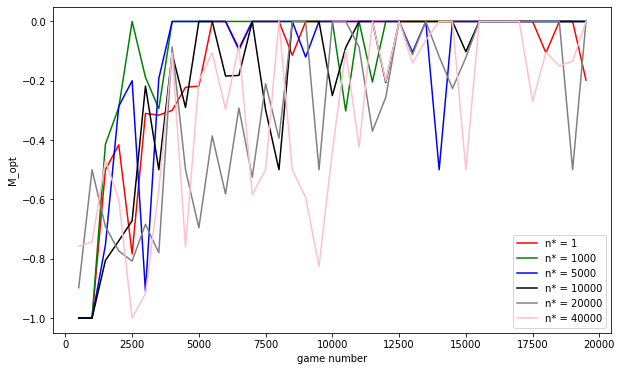

In [205]:
game_number = []
for i in range(40):
    game_number.append(500*i)
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(game_number[1:], M_opt[0][1:],color='r',label='n* = 1')
plt.plot(game_number[1:], M_opt[1][1:],color='g',label='n* = 1000')
plt.plot(game_number[1:], M_opt[2][1:],color='b',label='n* = 5000')
plt.plot(game_number[1:], M_opt[3][1:],color='black',label='n* = 10000')
plt.plot(game_number[1:], M_opt[4][1:],color='gray',label='n* = 20000')
plt.plot(game_number[1:], M_opt[5][1:],color='pink',label='n* = 40000')
plt.ylabel("M_opt")
plt.xlabel("game number")
plt.legend()
plt.savefig('Ques13a.png')
plt.savefig('Ques13a.pdf')
plt.show()

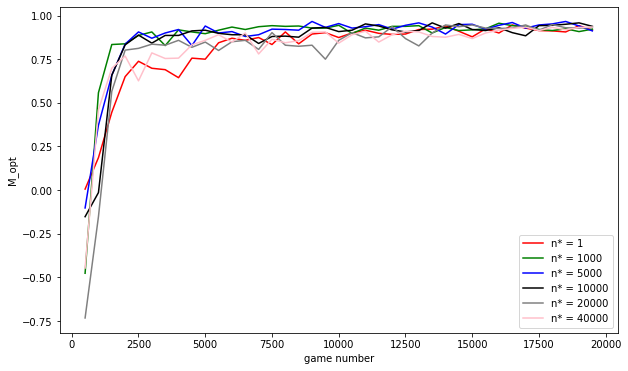

In [206]:
game_number = []
for i in range(40):
    game_number.append(500*i)
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(game_number[1:], M_rand[0][1:],color='r',label='n* = 1')
plt.plot(game_number[1:], M_rand[1][1:],color='g',label='n* = 1000')
plt.plot(game_number[1:], M_rand[2][1:],color='b',label='n* = 5000')
plt.plot(game_number[1:], M_rand[3][1:],color='black',label='n* = 10000')
plt.plot(game_number[1:], M_rand[4][1:],color='gray',label='n* = 20000')
plt.plot(game_number[1:], M_rand[5][1:],color='pink',label='n* = 40000')
plt.ylabel("M_opt")
plt.xlabel("game number")
plt.legend()
plt.savefig('Ques13b.png')
plt.savefig('Ques13b.pdf')
plt.show()

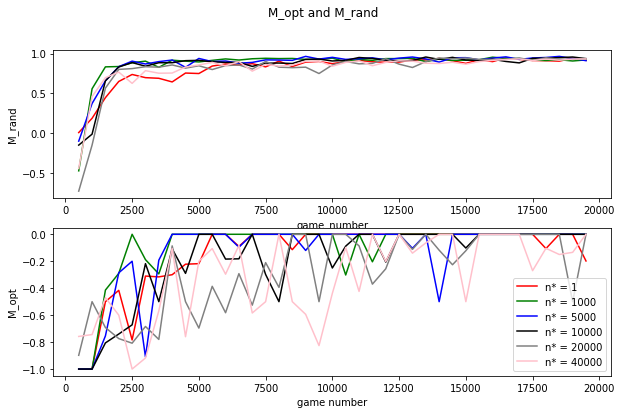

In [208]:
game_number = []
for i in range(40):
    game_number.append(500*i)

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('M_opt and M_rand')

ax1.plot(game_number[1:], M_rand[0][1:],color='r',label='n* = 1')
ax1.plot(game_number[1:], M_rand[1][1:],color='g',label='n* = 1000')
ax1.plot(game_number[1:], M_rand[2][1:],color='b',label='n* = 5000')
ax1.plot(game_number[1:], M_rand[3][1:],color='black',label='n* = 10000')
ax1.plot(game_number[1:], M_rand[4][1:],color='gray',label='n* = 20000')
ax1.plot(game_number[1:], M_rand[5][1:],color='pink',label='n* = 40000')

ax2.plot(game_number[1:], M_opt[0][1:],color='r',label='n* = 1')
ax2.plot(game_number[1:], M_opt[1][1:],color='g',label='n* = 1000')
ax2.plot(game_number[1:], M_opt[2][1:],color='b',label='n* = 5000')
ax2.plot(game_number[1:], M_opt[3][1:],color='black',label='n* = 10000')
ax2.plot(game_number[1:], M_opt[4][1:],color='gray',label='n* = 20000')
ax2.plot(game_number[1:], M_opt[5][1:],color='pink',label='n* = 40000')


ax1.set(xlabel='game_number', ylabel='M_rand')
ax2.set(xlabel='game_number', ylabel='M_opt')

plt.xlabel("game number")
plt.legend()
plt.savefig('Ques13c.png')
plt.savefig('Ques13c.pdf')
plt.show()

# Quesion 14 and 15

The code is on another notebook

# Question 16

In [215]:
## Function to swap the order of state e.g. swap the terms (:,:,0) and (:,:,1)
def swap_state(state):
    swapped_s = np.zeros((3,3,2))
    swapped_s[:,:,0] = state[:,:,1]
    swapped_s[:,:,1] = state[:,:,0]
    return swapped_s

In [238]:
##############MAIN TRAINING LOOP

M_opt = [[],[],[],[],[],[]]
M_rand = [[],[],[],[],[],[]]

epsilon_list = [0.0,0.2,0.4,0.6,0.8,0.99]


env.reset()
obs = env.observe()[0]
zero_state = env.observe()[0]

for z in range(6):

    policy_net = Network() 
    target_net = Network() 
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = torch.optim.Adam(policy_net.parameters(), lr=5e-4)
    replay_buffer = initialise_replay_buffer()

    for games in range(20000):
        
        env.reset()
        epsilon_moving = epsilon_list[z]
        obs = env.observe()[0]
        
        if games%2 == 0:
            player1 = "X"
            player2 = "O"
            
        if games%2 == 1:
            player1 = "O"
            player2 = "X"
            
            state101 = env.observe()[0]
            if epsilon_moving == 0.:
                best_action101 = policy_net.act(make_state_for_input(state101))

            else:
                random_number = np.random.randint(0,9)
                if random_number >= epsilon_moving*10:
                    best_action101 = policy_net.act(make_state_for_input(state101))
                else:
                    best_action101 = random_number

            env.step(best_action101)


        for rounds in range(5):
            
            #I play
            state_now = env.observe()[0]

            #selecting the best action considering the present state
            if epsilon_moving == 0.:
                best_action1 = policy_net.act(make_state_for_input(state_now))
            else:
                random_number = np.random.randint(0,9)
                if random_number >= epsilon_moving*10:
                    best_action1 = policy_net.act(make_state_for_input(state_now))
                else:
                    best_action1 = random_number
            
            ###For the case of taking unavailable action
            if state_now[list_of_action[best_action1]] != 0:
                end = True
                rew = -1
                transition = (state_now, best_action1, rew, end, zero_state)
                replay_buffer.append(transition)
                episode_reward += rew
                rew_buffer.append(episode_reward)
                episode_reward = 0.
                break

            
            #make the move with that best action
            env.step(best_action1)

            ##Adding transition from the player 2 (which is also us haha)
            if rounds >= 1:
                transition = (player2_now, best_action2, env.reward(player=player2), env.observe()[1], env.observe()[0])
                replay_buffer.append(transition)

            grid, _, __ = env.observe()
            
            if env.observe()[1] == True:
                rew = env.reward(player=player1)
                transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
                replay_buffer.append(transition)
                episode_reward += rew
                rew_buffer.append(episode_reward)
                episode_reward = 0.
                break
           
            player2_now = env.observe()[0]
            #selecting the best action considering the present state
            if epsilon_moving == 0.:
                best_action2 = policy_net.act(make_state_for_input(player2_now))
            else:
                random_number = np.random.randint(0,9)
                if random_number >= epsilon_moving*10:
                    best_action2 = policy_net.act(make_state_for_input(player2_now))
                else:
                    best_action2 = random_number


            if env.observe()[0][list_of_action[best_action2]] != 0:
                end = True
                rew = -1
                transition = (player2_now, best_action2, rew, end, zero_state)
                replay_buffer.append(transition)
                episode_reward += rew
                rew_buffer.append(episode_reward)
                episode_reward = 0.
                break

            env.step(best_action2)

            if env.observe()[1] == True:
                rew = env.reward(player=player1)
                rew2 = env.reward(player=player2)
                
                transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
                replay_buffer.append(transition)
                transition = (player2_now, best_action2, rew2, env.observe()[1], env.observe()[0])
                replay_buffer.append(transition)
                episode_reward += rew
                rew_buffer.append(episode_reward)
                episode_reward = 0.
                break

            #Gather information about the state the game is in after the computer played
            future_state = env.observe()[0]
            
            _, end, winner = env.observe()
            rew = env.reward(player=player1)                   
            transition = (state_now, best_action1, rew, end, future_state)
            replay_buffer.append(transition)
            episode_reward += rew
            




        ##START GRADIENT STEP
        transitions = random.sample(replay_buffer, BATCH_SIZE)

        obses = np.asarray([make_state_for_input(t[0]) for t in transitions])
        actions = np.asarray([t[1] for t in transitions])
        rew = np.asarray([t[2] for t in transitions])
        dones = np.asarray([t[3] for t in transitions])
        new_obses = np.asarray([make_state_for_input(t[4]) for t in transitions])

        obses_t = torch.as_tensor(obses, dtype=torch.float32)
        actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
        rews_t = torch.as_tensor(rew, dtype=torch.float32).unsqueeze(-1)
        dones_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
        new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32)

        target_q_values = target_net(new_obses_t)
        
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        
        targets = rews_t + GAMMA * (1 - dones_t) * max_target_q_values


        ###COMPUTE LOSS
        q_values = policy_net(obses_t)
        action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)

        loss = nn.functional.smooth_l1_loss(action_q_values, targets)

        ####GRADIENT STEP
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ####UPDATE TARGET NETWORK
        if games % TARGET_UPDATE_FREQ == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if games % 500 == 0:
            print("game",games)
            N_me, N_comp = number_wins(0.)
            print("M_opt",N_me,N_comp)
            M_opt[z].append((N_me-N_comp)/500)
            N_me, N_comp = number_wins(1.)
            print("M_rand",N_me,N_comp)
            M_rand[z].append((N_me-N_comp)/500)
        


game 0
M_opt 0 500
M_rand 0 500
game 500
M_opt 0 250
M_rand 268 163
game 1000
M_opt 0 197
M_rand 342 98
game 1500
M_opt 0 500
M_rand 283 170
game 2000
M_opt 0 250
M_rand 314 127
game 2500
M_opt 0 500
M_rand 365 83
game 3000
M_opt 0 461
M_rand 310 143
game 3500
M_opt 0 250
M_rand 315 139
game 4000
M_opt 0 250
M_rand 382 99
game 4500
M_opt 0 500
M_rand 375 92
game 5000
M_opt 0 500
M_rand 327 137
game 5500
M_opt 0 500
M_rand 311 137
game 6000
M_opt 0 366
M_rand 376 86
game 6500
M_opt 0 500
M_rand 300 154
game 7000
M_opt 0 500
M_rand 328 124
game 7500
M_opt 0 250
M_rand 329 129
game 8000
M_opt 0 250
M_rand 321 147
game 8500
M_opt 0 250
M_rand 359 96
game 9000
M_opt 0 199
M_rand 330 133
game 9500
M_opt 0 250
M_rand 327 143
game 10000
M_opt 0 250
M_rand 337 133
game 10500
M_opt 0 250
M_rand 338 113
game 11000
M_opt 0 250
M_rand 344 123
game 11500
M_opt 0 374
M_rand 256 182
game 12000
M_opt 0 250
M_rand 347 111
game 12500
M_opt 0 500
M_rand 320 163
game 13000
M_opt 0 199
M_rand 312 145
game 1

KeyboardInterrupt: 

# Question 17

In [241]:
##############MAIN TRAINING LOOP

M_opt = [[],[],[],[],[],[]]
M_rand = [[],[],[],[],[],[]]


n_star_list = [1,1000,5000,10000,20000,40000]


env.reset()
obs = env.observe()[0]
zero_state = env.observe()[0]


for z in range(6):
    print(z)
    policy_net = Network() 
    target_net = Network() 
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = torch.optim.Adam(policy_net.parameters(), lr=5e-4)
    replay_buffer = initialise_replay_buffer()

    for games in range(20000):
        
        env.reset()
        epsilon_moving = epsilon_fxn(games,n_star_list[z])
        obs = env.observe()[0]

        if games%2 == 0:
            player1 = "X"
            player2 = "O"
            
        if games%2 == 1:
            player1 = "O"
            player2 = "X"
            
            state101 = env.observe()[0]
            if epsilon_moving == 0.:
                best_action101 = policy_net.act(make_state_for_input(state101))

            else:
                random_number = np.random.randint(0,9)
                if random_number >= epsilon_moving*10:
                    best_action101 = policy_net.act(make_state_for_input(state101))
                else:
                    best_action101 = random_number

            env.step(best_action101)


        for rounds in range(5):
            
            #I play
            state_now = env.observe()[0]
            #selecting the best action considering the present state
            if epsilon_moving == 0.:
                best_action1 = policy_net.act(make_state_for_input(state_now))
            else:
                random_number = np.random.randint(0,9)
                if random_number >= epsilon_moving*10:
                    best_action1 = policy_net.act(make_state_for_input(state_now))
                else:
                    best_action1 = random_number
            
            ###Case: taking unavailable action
            if state_now[list_of_action[best_action1]] != 0:
                end = True
                rew = -1
                transition = (state_now, best_action1, rew, end, zero_state)
                replay_buffer.append(transition)
                episode_reward += rew
                rew_buffer.append(episode_reward)
                episode_reward = 0.
                break

            
            #make the move with that best action
            env.step(best_action1)

            if rounds >= 1:
                transition = (player2_now, best_action2, env.reward(player=player2), env.observe()[1], env.observe()[0])
                replay_buffer.append(transition)

            
            grid, _, __ = env.observe()
            
            if env.observe()[1] == True:
                rew = env.reward(player=player1)
                transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
                replay_buffer.append(transition)
                episode_reward += rew
                rew_buffer.append(episode_reward)
                episode_reward = 0.
                break

            player2_now = env.observe()[0]
            #selecting the best action considering the present state
            if epsilon_moving == 0.:
                best_action2 = policy_net.act(make_state_for_input(player2_now))
            else:
                random_number = np.random.randint(0,9)
                if random_number >= epsilon_moving*10:
                    best_action2 = policy_net.act(make_state_for_input(player2_now))
                else:
                    best_action2 = random_number


            if env.observe()[0][list_of_action[best_action2]] != 0:
                end = True
                rew = -1
                transition = (player2_now, best_action2, rew, end, zero_state)
                replay_buffer.append(transition)
                episode_reward += rew
                rew_buffer.append(episode_reward)
                episode_reward = 0.
                break

            env.step(best_action2)

            if env.observe()[1] == True:
                rew = env.reward(player=player1)
                rew2 = env.reward(player=player2)
                transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
                replay_buffer.append(transition)
                transition = (player2_now, best_action2, rew2, env.observe()[1], env.observe()[0])
                replay_buffer.append(transition)
                episode_reward += rew
                rew_buffer.append(episode_reward)
                episode_reward = 0.
                break

            #Gather information about the state the game is in after the computer played
            future_state = env.observe()[0]
            
            _, end, winner = env.observe()
            rew = env.reward(player=player1)                    
            transition = (state_now, best_action1, rew, end, future_state)
            replay_buffer.append(transition)
            episode_reward += rew
            




        ##START GRADIENT STEP
        transitions = random.sample(replay_buffer, BATCH_SIZE)

        obses = np.asarray([make_state_for_input(t[0]) for t in transitions])
        actions = np.asarray([t[1] for t in transitions])
        rew = np.asarray([t[2] for t in transitions])
        dones = np.asarray([t[3] for t in transitions])
        new_obses = np.asarray([make_state_for_input(t[4]) for t in transitions])

        obses_t = torch.as_tensor(obses, dtype=torch.float32)
        actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
        rews_t = torch.as_tensor(rew, dtype=torch.float32).unsqueeze(-1)
        dones_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
        new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32)

        target_q_values = target_net(new_obses_t)
        
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        
        targets = rews_t + GAMMA * (1 - dones_t) * max_target_q_values


        ###COMPUTE LOSS
        q_values = policy_net(obses_t)
        action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)

        loss = nn.functional.smooth_l1_loss(action_q_values, targets)

        ####GRADIENT STEP
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ####UPDATE TARGET NETWORK
        if games % TARGET_UPDATE_FREQ == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if games%250 == 0:
            
            N_me, N_comp = number_wins(0.)
            M_opt[z].append((N_me-N_comp)/500)
            N_me, N_comp = number_wins(1.)
            M_rand[z].append((N_me-N_comp)/500)



0
1
2
3
4
5


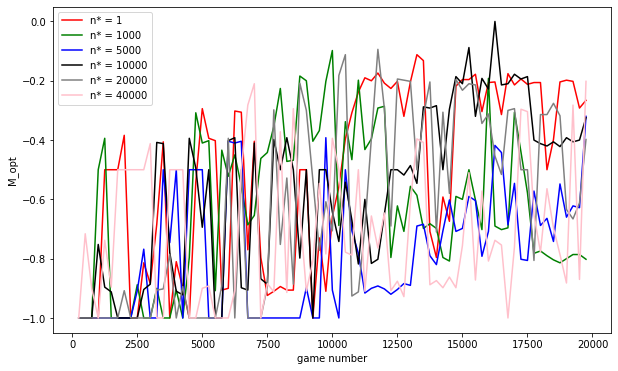

In [245]:
game_number = []
for i in range(80):
    game_number.append(250*i)
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(game_number[1:], M_opt[0][1:],color='r',label='n* = 1')
plt.plot(game_number[1:], M_opt[1][1:],color='g',label='n* = 1000')
plt.plot(game_number[1:], M_opt[2][1:],color='b',label='n* = 5000')
plt.plot(game_number[1:], M_opt[3][1:],color='black',label='n* = 10000')
plt.plot(game_number[1:], M_opt[4][1:],color='gray',label='n* = 20000')
plt.plot(game_number[1:], M_opt[5][1:],color='pink',label='n* = 40000')
plt.ylabel("M_opt")
plt.xlabel("game number")
plt.legend()
plt.savefig('Ques17a.png')
plt.savefig('Ques17a.pdf')
plt.show()

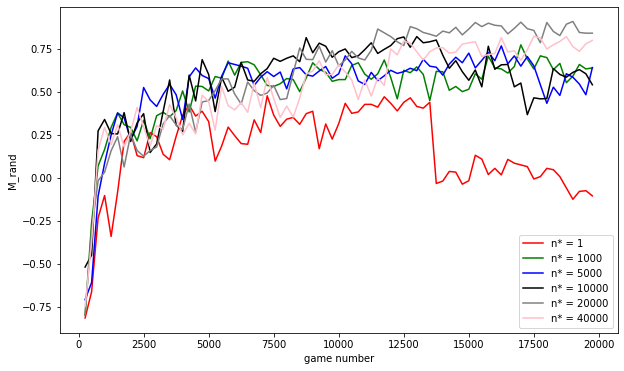

In [246]:
game_number = []
for i in range(80):
    game_number.append(250*i)
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(game_number[1:], M_rand[0][1:],color='r',label='n* = 1')
plt.plot(game_number[1:], M_rand[1][1:],color='g',label='n* = 1000')
plt.plot(game_number[1:], M_rand[2][1:],color='b',label='n* = 5000')
plt.plot(game_number[1:], M_rand[3][1:],color='black',label='n* = 10000')
plt.plot(game_number[1:], M_rand[4][1:],color='gray',label='n* = 20000')
plt.plot(game_number[1:], M_rand[5][1:],color='pink',label='n* = 40000')
plt.ylabel("M_rand")
plt.xlabel("game number")
plt.legend()
plt.savefig('Ques17b.png')
plt.savefig('Ques17b.pdf')
plt.show()

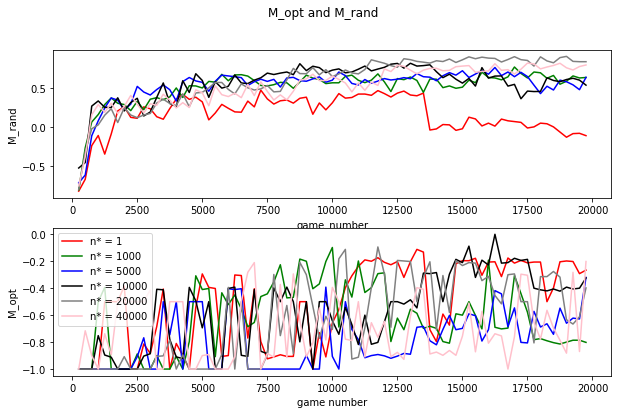

In [247]:
game_number = []
for i in range(80):
    game_number.append(250*i)

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('M_opt and M_rand')

ax1.plot(game_number[1:], M_rand[0][1:],color='r',label='n* = 1')
ax1.plot(game_number[1:], M_rand[1][1:],color='g',label='n* = 1000')
ax1.plot(game_number[1:], M_rand[2][1:],color='b',label='n* = 5000')
ax1.plot(game_number[1:], M_rand[3][1:],color='black',label='n* = 10000')
ax1.plot(game_number[1:], M_rand[4][1:],color='gray',label='n* = 20000')
ax1.plot(game_number[1:], M_rand[5][1:],color='pink',label='n* = 40000')

ax2.plot(game_number[1:], M_opt[0][1:],color='r',label='n* = 1')
ax2.plot(game_number[1:], M_opt[1][1:],color='g',label='n* = 1000')
ax2.plot(game_number[1:], M_opt[2][1:],color='b',label='n* = 5000')
ax2.plot(game_number[1:], M_opt[3][1:],color='black',label='n* = 10000')
ax2.plot(game_number[1:], M_opt[4][1:],color='gray',label='n* = 20000')
ax2.plot(game_number[1:], M_opt[5][1:],color='pink',label='n* = 40000')


#ax1.plot(game_number[1:],average_reward[1:],color='r',label='average_reward')
#ax2.plot(game_number[1:],average_loss[1:], color="b",label="average_loss")

ax1.set(xlabel='game_number', ylabel='M_rand')
ax2.set(xlabel='game_number', ylabel='M_opt')

plt.xlabel("game number")
plt.legend()
plt.savefig('Ques17c.png')
plt.savefig('Ques17c.pdf')
plt.show()

In [248]:
np.max(M_opt), np.max(M_rand)

(0.0, 0.908)

In [253]:
np.max(M_opt[4]), np.max(M_rand[4])

(-0.094, 0.908)

# Question 19

In [255]:
##############MAIN TRAINING LOOP
#running with best n*
M_opt = []
M_rand = []


env.reset()
obs = env.observe()[0]
zero_state = env.observe()[0]


for z in range(1):
    print(z)
    policy_net = Network() 
    target_net = Network() 
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = torch.optim.Adam(policy_net.parameters(), lr=5e-4)
    replay_buffer = initialise_replay_buffer()

    for games in range(20000):
        
        env.reset()
        epsilon_moving = epsilon_fxn(games,20000)
        obs = env.observe()[0]
       
        if games%2 == 0:
            player1 = "X"
            player2 = "O"
            
        if games%2 == 1:
            player1 = "O"
            player2 = "X"
            
            state101 = env.observe()[0]
            if epsilon_moving == 0.:
                best_action101 = policy_net.act(make_state_for_input(state101))

            else:
                random_number = np.random.randint(0,9)
                if random_number >= epsilon_moving*10:
                    best_action101 = policy_net.act(make_state_for_input(state101))
                else:
                    best_action101 = random_number

            env.step(best_action101)


        for rounds in range(5):
            
            #I play
            state_now = env.observe()[0]

            #selecting the best action considering the present state
            if epsilon_moving == 0.:
                best_action1 = policy_net.act(make_state_for_input(state_now))
            else:
                random_number = np.random.randint(0,9)
                if random_number >= epsilon_moving*10:
                    best_action1 = policy_net.act(make_state_for_input(state_now))
                else:
                    best_action1 = random_number
            
            ###If you can not take the action??
            if state_now[list_of_action[best_action1]] != 0:
                end = True
                rew = -1
                transition = (state_now, best_action1, rew, end, zero_state)
                replay_buffer.append(transition)
                episode_reward += rew
                rew_buffer.append(episode_reward)
                episode_reward = 0.
                break

            
            #make the move with that best action
            env.step(best_action1)

            if rounds >= 1:
                transition = (player2_now, best_action2, env.reward(player=player2), env.observe()[1], env.observe()[0])
                replay_buffer.append(transition)

            
            grid, _, __ = env.observe()
            
            if env.observe()[1] == True:
                rew = env.reward(player=player1)
                #print(rew,player1)
                #current_average_reward += rew
                transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
                replay_buffer.append(transition)
                episode_reward += rew
                rew_buffer.append(episode_reward)
                episode_reward = 0.
                break
            
            #player 2 plays
            player2_now = env.observe()[0]
            #selecting the best action considering the present state
            if epsilon_moving == 0.:
                best_action2 = policy_net.act(make_state_for_input(player2_now))
            else:
                random_number = np.random.randint(0,9)
                if random_number >= epsilon_moving*10:
                    best_action2 = policy_net.act(make_state_for_input(player2_now))
                else:
                    best_action2 = random_number



            if env.observe()[0][list_of_action[best_action2]] != 0:
                end = True
                rew = -1
                transition = (player2_now, best_action2, rew, end, zero_state)
                replay_buffer.append(transition)
                episode_reward += rew
                rew_buffer.append(episode_reward)
                episode_reward = 0.
                break

            env.step(best_action2)

            if env.observe()[1] == True:
                rew = env.reward(player=player1)
                rew2 = env.reward(player=player2)
                transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
                replay_buffer.append(transition)
                transition = (player2_now, best_action2, rew2, env.observe()[1], env.observe()[0])
                replay_buffer.append(transition)
                episode_reward += rew
                rew_buffer.append(episode_reward)
                episode_reward = 0.
                break

            #Gather information about the state the game is in after the computer played
            future_state = env.observe()[0]
            
            _, end, winner = env.observe()
            rew = env.reward(player=player1)                    
            transition = (state_now, best_action1, rew, end, future_state)
            replay_buffer.append(transition)
            episode_reward += rew
            

        ##START GRADIENT STEP
        transitions = random.sample(replay_buffer, BATCH_SIZE)

        obses = np.asarray([make_state_for_input(t[0]) for t in transitions])
        actions = np.asarray([t[1] for t in transitions])
        rew = np.asarray([t[2] for t in transitions])
        dones = np.asarray([t[3] for t in transitions])
        new_obses = np.asarray([make_state_for_input(t[4]) for t in transitions])

        obses_t = torch.as_tensor(obses, dtype=torch.float32)
        actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
        rews_t = torch.as_tensor(rew, dtype=torch.float32).unsqueeze(-1)
        dones_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
        new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32)

        target_q_values = target_net(new_obses_t)
        
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        
        targets = rews_t + GAMMA * (1 - dones_t) * max_target_q_values


        ###COMPUTE LOSS
        q_values = policy_net(obses_t)
        action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)

        loss = nn.functional.smooth_l1_loss(action_q_values, targets)

        ####GRADIENT STEP
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ####UPDATE TARGET NETWORK
        if games % TARGET_UPDATE_FREQ == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if games%1000 == 0:
            
            N_me, N_comp = number_wins(0.)
            M_opt.append((N_me-N_comp)/500)
            N_me, N_comp = number_wins(1.)
            M_rand.append((N_me-N_comp)/500)


        


0


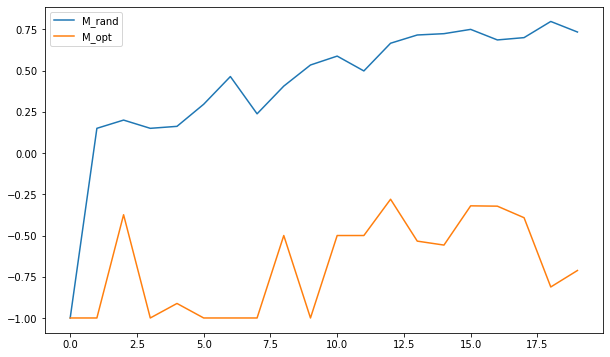

In [256]:
plt.plot(M_rand,label="M_rand")
plt.plot(M_opt,label="M_opt")
plt.legend()
plt.show()

### State prep
### State 1

In [257]:
##Preparing a state to see what our network predicts

env.reset()
env.step(0)
env.step(2)
env.step(4)
env.step(5)


env.render()

|X - O|
|- X O|
|- - -|



In [263]:
## Creating the input for the network from the state in the environment
obses = np.asarray(make_state_for_input(env.observe()[0]))
obses_t = torch.as_tensor(obses, dtype=torch.float32)
obses_t

tensor([[[1., 0.],
         [0., 0.],
         [0., 1.]],

        [[0., 0.],
         [1., 0.],
         [0., 1.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]]])

In [264]:
#getting the q values 
q_values = policy_net(obses_t[None,:,:,:])
q_values

tensor([[-0.5315, -0.0891, -0.9385, -0.5154, -0.9696, -1.9018, -0.8414,  0.1105,
          1.2994]], grad_fn=<AddmmBackward0>)

In [274]:
#getting matrix for heatmap
data_heat = np.zeros((3,3))
for i in range(9):
    data_heat[list_of_action[i]] = q_values[0,i].item()

data_heat

array([[-0.53145492, -0.0891476 , -0.93854368],
       [-0.51539654, -0.96956563, -1.90178919],
       [-0.84143913,  0.1105068 ,  1.29940677]])

|X - O|
|- X O|
|- - -|



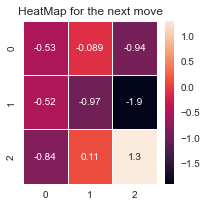

In [277]:
##showing the heatmap
env.render()
plt.style.use("seaborn")

plt.figure(figsize=(3,3))
heat_map = sns.heatmap( data_heat, linewidth = 1 , annot = True)
plt.title( "HeatMap for the next move" )
plt.show()

### State 2
repeating the steps done above for other two states


In [278]:
env.reset()
env.step(0)
env.step(2)
env.step(4)


env.render()

|X - O|
|- X -|
|- - -|



In [279]:
obses = np.asarray(make_state_for_input(env.observe()[0]))
obses_t = torch.as_tensor(obses, dtype=torch.float32)
q_values = policy_net(obses_t[None,:,:,:])

data_heat = np.zeros((3,3))
for i in range(9):
    data_heat[list_of_action[i]] = q_values[0,i].item()

data_heat


array([[-0.81600595, -1.42263389, -1.46933699],
       [-1.04070079, -1.87452292, -0.65580308],
       [-1.99656439, -1.49068773, -0.10340236]])

|X - O|
|- X -|
|- - -|



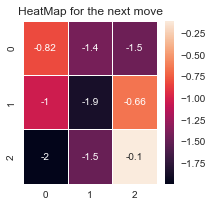

In [280]:
env.render()
plt.style.use("seaborn")

plt.figure(figsize=(3,3))
heat_map = sns.heatmap( data_heat, linewidth = 1 , annot = True)
plt.title( "HeatMap for the next move" )
plt.show()

### State 3

In [284]:
env.reset()
env.step(0)
env.step(2)
env.step(4)
env.step(8)
env.step(5)
#env.step(8)

env.render()

|X - O|
|- X X|
|- - O|



In [285]:
obses = np.asarray(make_state_for_input(env.observe()[0]))
obses_t = torch.as_tensor(obses, dtype=torch.float32)
q_values = policy_net(obses_t[None,:,:,:])

data_heat = np.zeros((3,3))
for i in range(9):
    data_heat[list_of_action[i]] = q_values[0,i].item()

data_heat

array([[-0.7520014 , -1.05040264, -1.02317381],
       [ 0.38148978, -2.22560191, -1.47728777],
       [-0.58156168, -0.33578184, -0.86378795]])

|X - O|
|- X X|
|- - O|



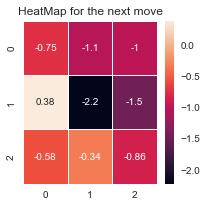

In [286]:
env.render()
plt.style.use("seaborn")

plt.figure(figsize=(3,3))
heat_map = sns.heatmap( data_heat, linewidth = 1 , annot = True)
plt.title( "HeatMap for the next move" )
plt.show()